# Hofstadter Model and its Topology(Julia Version)

About the author: 
Jiaqi Cai, University of Washington, Email: caidish at uw.edu

In [3]:
# import essential package
using LinearAlgebra, Statistics, Compat, Plots, LaTeXStrings, SparseArrays

In this notebook, we show how to use Julia to simulate quantum Hall effect. We mainly focus on Hofstadter model, the Hamiltonian of which is simply:
$$H = \sum_{m,n} - t(c^\dagger_{m+1,n}c_{m,n} + c_{m,n+1}^\dagger c_{m,n}e^{i 2\pi \Phi m} + h.c.)$$

## Energy Band
When the flux is commensurable, i.e., $\Phi = \frac{p}{q}$, the model have well defined Bloch excitations, which are band electrons with $q$ bands. The eigen equations can be easily obtained: $-2t\cos(k_x + 2\pi \Phi n)\psi_n - t(e^{-ik_y}\psi_{n-1} + e^{ik_y}\psi_{n+1}) = E_{k_x,k_y}\psi_n$ where $n = 1,...,q$ and the boudary condition is $\psi_{j+q}= \psi_{j}$. Solving the linear system above will give the band structure of Hofstadter model. 

In [5]:
function TorusHamiltonian(kx,ky,t,p,q)::Array{Complex{Float64},2}
    Phi   = p/q
    diagL = -t*exp(-1*im*ky)*ones(q-1)
    diagD = complex(-2*t*cos.(kx*ones(q) + 2*pi*Phi*collect(0:1:q-1)))
    diagR = -t*exp(+1*im*ky)*ones(q-1)
    H = convert(Array,Tridiagonal(diagL,diagD,diagR))
    # We use the method Tridiagonal to setup the matrix, and convert it to normal
    # matrix to define the boundary condition
    H[q,1] = -t*exp(+1*im*ky)
    H[1,q] = -t*exp(-1*im*ky)
    # The bouandary condition is set. 
    return H
    end;

Let's try to use the Hamiltonian defined in the BZ (geometrically a torus) to generate the band.

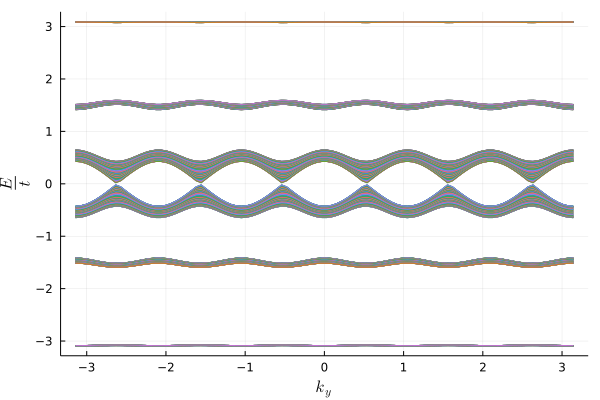

In [6]:
p = 1
q = 6
t = 1
kx_step = 100
ky_step = 100
kx_list = LinRange(-pi/q,pi/q,kx_step)
ky_list = LinRange(-pi  ,pi  ,ky_step)
バンド  = zeros(ky_step,kx_step,q)
for (m,kx) = enumerate(kx_list)
    for (n,ky) = enumerate(ky_list)
    バンド[n,m,:] = eigvals(TorusHamiltonian(kx,ky,t,p,q))
    end
end
#result = permutedims(result,(2,1,3))
バンド = reshape(バンド,(ky_step,kx_step*q))
plot(ky_list,バンド,legend=false,xlabel = L"k_y",ylabel = L"\frac{E}{t}")

I deliberately use Unicode "バンド"(energy band in Japanese) for the result to show the Unicode capability of Julia. Please see the winding number protected Dirac fermion near the charge neutral point. 

## Edge state and Chern number
In this section we show have to calculate the edge state spectrum and the Chern number of the band.

### Edge state
Let's see what will happen if we cut the torus into a cylinder, namely only $k_y$ is defined, the eigen equation for this case is: $-t(\psi_{m+1}(k_y) + \psi_{m-1}(k_y)) -2t \cos(k_y - 2\pi\Phi m) \psi_m(k_y) = E\psi_m(k_y)$, 
where $m = 1,...,N$ and $N$ is the length of the cylinder, with a hard boundary condition $\psi_0 = \psi_{N+1} = 0$.

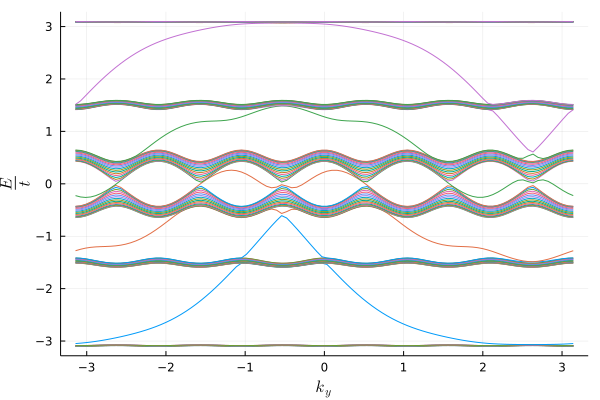

In [8]:
function CylindricHamiltonian(ky,N,t,Phi)::Array{Complex{Float64},2}
    diagL = -t*ones(N-1)
    diagD = -2*t*cos.(ky*ones(N) - 2*pi*Phi*collect(1:1:N))
    diagR = -t*ones(N-1)
    H = convert(Array,Tridiagonal(diagL,diagD,diagR))
    return H
    end
p = 1
q = 6
Phi = p/q
t = 1
ky_step = 100
N = 100
ky_list = range(-pi,stop = pi,length=ky_step)
result = zeros(ky_step,N)
for (m,ky) = enumerate(ky_list)
    result[m,:] = eigvals(CylindricHamiltonian(ky,N,t,Phi))
end
plot(ky_list,result,legend=false,xlabel = L"k_y",ylabel = L"\frac{E}{t}")

## Calculate the Chern number: TKNN method
Here the TKNN formula of Berry curvature (and then Chern number) is used to compute the Chern number.

In [9]:
function ChernNumberByTKNN(H,Hkx,Hky,N,xv,yv,Nx,Ny)
    #H is the function of (kx,ky) to give the Hamiltonian. 
    #Hkx is the kx derivative of H and Hky is the ky derivative of H
    #N denotes the number of band. xv,yv define the boundary of the Brioullion zone
    #Nx,Ny is the meshes for Chern number
    lower_x = minimum(xv)
    higher_x = maximum(xv)
    lower_y = minimum(yv)
    higher_y = maximum(yv)
    x_list = collect(range(lower_x,stop = higher_x,length = Nx))
    dx = x_list[2] - x_list[1]
    y_list = collect(range(lower_y,stop = higher_y,length = Ny))
    dy = y_list[2] - y_list[1]
    B = zeros(Nx,Ny,N)
    C = zeros(N)
    for (numX,kx) = enumerate(x_list)
        for (numY,ky) = enumerate(y_list)
            F = eigen(H(kx,ky))
            Wave = F.vectors
            Eigen = F.values
            p = sortperm(Eigen)
            Eigen = Eigen[p]
            Wave  = Wave[:,p]
            Okx = Hkx(kx,ky)
            Oky = Hky(kx,ky)
            for n = 1:N
                for m = 1:N
                    if m!=n
                        ketn = Wave[:,n]
                        ketm = Wave[:,m]
                        En   = Eigen[n]
                        Em   = Eigen[m]
                        #println(ketn)
                        #println(ketm)
                        #println(Okx)
                        #println(Oky)
                        #println(imag(ketn'*Okx*ketm * ketm'*Oky*ketn - ketn'*Oky*ketm * ketm'*Okx*ketn)/(Em-En)^2)
                        B[numX,numY,n] += -imag(ketn'*Okx*ketm * ketm'*Oky*ketn - ketn'*Oky*ketm * ketm'*Okx*ketn)/(Em-En)^2
                    end
                end
            end
        end
    end
    for i = 1:N
        C[i] = 1/(2*pi)*sum(B[:,:,i])*dx*dy
    end
    return C
    end

function TorusHkx(kx,ky,t,p,q)::Array{Complex{Float64},2}
    Phi   = p/q
    diagL = zeros(Complex,q-1)
    diagD = convert(Array{Complex,1},2*t*sin.(kx*ones(q) + 2*pi*Phi*collect(0:1:q-1)))
    diagR = zeros(Complex,q-1)
    H = convert(Array,Tridiagonal(diagL,diagD,diagR))
    # We use the method Tridiagonal to setup the matrix, and convert it to normal
    # matrix to define the boundary condition
    H[q,1] = 0
    H[1,q] = 0
    # The bouandary condition is set. 
    return H
end

function TorusHky(kx,ky,t,p,q)::Array{Complex{Float64},2}
    Phi   = p/q
    diagL = im*t*exp(-1*im*ky)*ones(q-1)
    diagD = complex(0*ones(q))
    diagR = -im*t*exp(+1*im*ky)*ones(q-1)
    H = convert(Array,Tridiagonal(diagL,diagD,diagR))
    # We use the method Tridiagonal to setup the matrix, and convert it to normal
    # matrix to define the boundary condition
    H[q,1] = -im*t*exp(+1*im*ky)
    H[1,q] = im*t*exp(-1*im*ky)
    # The bouandary condition is set. 
    return H
    end;
p = 1
q = 6
t = 1
kx_step = 100
ky_step = 100
kx = [-pi,pi]
ky = [-pi,pi]
H = (kx,ky)->TorusHamiltonian(kx,ky,t,p,q)
Hkx=(kx,ky)->TorusHkx(kx,ky,t,p,q)
Hky=(kx,ky)->TorusHky(kx,ky,t,p,q)
C = ChernNumberByTKNN(H,Hkx,Hky,q,kx,ky,kx_step,ky_step)/q
for n = 1:q
println("The $n-th Chern Number is: " * string(C[n]))
end

The 1-th Chern Number is: -1.0187478474466722
The 2-th Chern Number is: -1.0445831127776704
The 3-th Chern Number is: 2.063330960224348
The 4-th Chern Number is: 2.0633309602243295
The 5-th Chern Number is: -1.044583112777662
The 6-th Chern Number is: -1.0187478474466733


Now we can see the band chern number is [-1,-1,4,-1,-1] for five band. 

## Calculate the Chern number: wilson loop method
We then want to calculate the Chern number of each band. The method is to use wilson loop. If you are not familiar with this method, please refer to this paper: https://arxiv.org/abs/cond-mat/0503172. 

In [11]:
function ChernNumberByWilsonLoop(H,n,xv,yv,Nx,Ny)
    #H is the function of (kx,ky) to give the Hamiltonian. 
    #n denotes n-th band. xv,yv define the boundary of the Brioullion zone
    #Nx,Ny is the meshes for Chern number
    lower_x = minimum(xv)
    higher_x = maximum(xv)
    lower_y = minimum(yv)
    higher_y = maximum(yv)
    x_list = collect(range(lower_x,stop = higher_x,length = Nx))
    dx = x_list[2] - x_list[1]
    y_list = collect(range(lower_y,stop = higher_y,length = Ny))
    dy = y_list[2] - y_list[1]
    append!(x_list,[higher_x + dx,higher_x + 2*dx])
    append!(y_list,[higher_y + dy,higher_y + 2*dy])

    U_x_list = zeros(Complex,Nx+1,Ny+1)
    U_y_list = zeros(Complex,Nx+1,Ny+1)

    W_list   = zeros(Complex,Nx,Ny)
    for (num_y,ky) = enumerate(y_list[1:Ny+1])
        Wave1 = sortWave(H(x_list[1],ky),n)
        for num_x = 1:Nx+1
            Wave2 = sortWave(H(x_list[num_x + 1],ky),n)
            U_x_list[num_x,num_y] = Wave2'*Wave1;
            Wave1 = Wave2
        end
    end
    for (num_x,kx) = enumerate(x_list[1:Nx+1])
        Wave1 = sortWave(H(kx,y_list[1]),n)
        for num_y = 1:Ny+1
            Wave2 = sortWave(H(kx,y_list[num_y + 1]),n)
            U_y_list[num_x,num_y] = Wave2'*Wave1;
            Wave1 = Wave2
        end
    end
    for num_x = 1:Nx
    for num_y = 1:Ny
                W_list[num_x,num_y] = U_x_list[num_x,num_y]*U_y_list[num_x+1,num_y]*conj(U_x_list[num_x,num_y+1])*conj(U_y_list[num_x,num_y])
    end
    end
    B = angle.(W_list)
    return 1/(2*pi)*sum(B[:])
end

function sortWave(M,n)
        F = eigen(M)
        Wave = F.vectors
        Eigen = F.values
        p = sortperm(Eigen)
        Eigen = Eigen[p]
        Wave  = Wave[:,p]
        return Wave[:,n]
    end

p = 1
q = 6
t = 1
kx_step = 100
ky_step = 100
kx = [-pi,pi]
ky = [-pi,pi]
H = (kx,ky)->TorusHamiltonian(kx,ky,t,p,q)
for n = 1:q
println("The $n-th Chern Number is: " * string(ChernNumberByWilsonLoop(H,n,kx,ky,kx_step,ky_step)/q))
end

The 1-th Chern Number is: -1.018781432213558
The 2-th Chern Number is: -1.0437354586033607
The 3-th Chern Number is: 5.062544010724828
The 4-th Chern Number is: 5.06254401072483
The 5-th Chern Number is: -1.0437354586033611
The 6-th Chern Number is: -1.018781432213558


## Finite size wave function and edge state
So now we've already known that there is nontrivial topology and its corresponding edge state, we may compute a real finite size lattice and see the wave funciton in the topological gap. The single particle Hamiltonian is: $H = \sum_{m,n}-t (\left|m+1,n\right\rangle \left\langle m,n\right|+e^{i2\pi\Phi m}\left|m,n+1\right\rangle \left\langle m,n\right|+ h.c.) $, where $\left|m,n\right\rangle = \left|m\right\rangle \otimes \left|n\right\rangle $ and $\otimes$ denotes the kronecker tensor.

In [12]:
# we first test the indexing of the kronecker

a = [1 0 0 0]'#ket{1}
b = [0 0 1 0]'#ket{3}
c = kron(a,b)'#ket{3,1}
function index(m,n,M,N)
   index = m + M*(n-1) 
end
println(c[index(3,1,4,4)])

a1 = [0 1 0 0]'#ket{2}
b1 = [0 0 0 1]'#ket{4}
c1 = kron(a1,b1)'#ket{4,2}
println(c1[index(4,2,4,4)])

Mat = c1'*c #bra{4,2}*ket{3,1}
println(Mat[index(4,2,4,4),index(3,1,4,4)])

1
1
1


The code below generates Hilbert basis via dense matrix manipulation, which is SUPER SLOW and should never be used.

In [13]:
#function that give the ket{i,j}
function basis_dense(i,j,M,N)
    res = zeros(Complex,M*N,1)
    res[index(i,j,M,N),1] = 1
    return res
end

# function that give the bra{m,n}*ket{i,j}
function mat_dense(m,n,i,j,M,N)
    res = zeros(Complex,M*N,M*N)
    res[index(m,n,M,N),index(i,j,M,N)] = 1
    return res
end

mat_dense (generic function with 1 method)

we may use the sparse matrix to give the Hamiltonian and the matrix

In [15]:
println(sparse([3,2],[3,2],[1.0im,2im],5,5))
println(spzeros(Complex{Float64}, 5,5))

function basis_sp(i,j,M,N)
    res = sparse([index(i,j,M,N)],[1],[1 + 0.0im],M*N,1)
end

function mat_sp(m,n,i,j,M,N)
    res = sparse([index(m,n,M,N)],[index(i,j,M,N)],[1],M*N,M*N)
end

sparse([2, 3], [2, 3], ComplexF64[0.0 + 2.0im, 0.0 + 1.0im], 5, 5)
sparse(Int64[], Int64[], ComplexF64[], 5, 5)


mat_sp (generic function with 1 method)

Now we know what is a sparse matrix, let's construct our Hamiltonian by sort all the indexes and the value. 

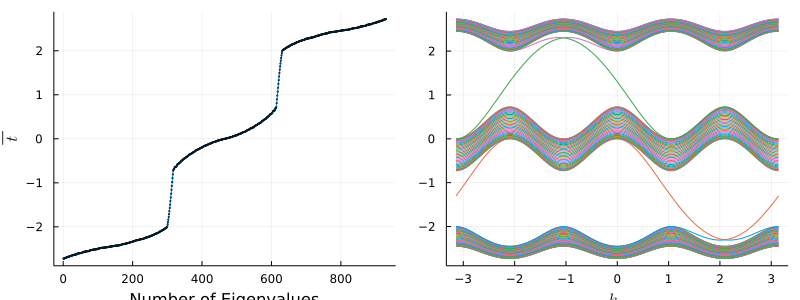

In [17]:
function FiniteHamiltonian(t,p,q,M,N)::SparseMatrixCSC{Complex{Float64},Int64}
    dim = M*N
    row_list = []
    col_list = []
    val_list = []
    for m = 1:M-1
        for n = 1:N
            append!(row_list,index(m+1,n,M,N))
            append!(col_list,index(m,n,M,N))
            append!(val_list,-t*(1+0.0im))

            append!(row_list,index(m,n,M,N))
            append!(col_list,index(m+1,n,M,N))
            append!(val_list,-t*(1+0.0im))
        end
    end
    for m = 1:M
        for n = 1:N-1
            append!(row_list,index(m,n+1,M,N))
            append!(col_list,index(m,n,M,N))
            append!(val_list,-t*exp(1im*2*pi*p/q*m))

            append!(row_list,index(m,n,M,N))
            append!(col_list,index(m,n+1,M,N))
            append!(val_list,-t*exp(-1im*2*pi*p/q*m))
        end
    end
    H = sparse(row_list,col_list,val_list,M*N,M*N)
    return H
end

t = 1
p = 1
q = 3
M = 30
N = 31
H = FiniteHamiltonian(t,p,q,M,N)
F = eigen(Array(H))
Wave = F.vectors
Eigen = F.values
perm = sortperm(Eigen)
Eigen = Eigen[perm]
Wave  = Wave[:,perm]
p1 = plot(Eigen,marker =(:c,1),xlabel = "Number of Eigenvalues",ylabel = L"\frac{E}{t}")

Phi = p/q
ky_step = 100
Nky = 100
ky_list = range(-pi,stop = pi,length=ky_step)
result = zeros(ky_step,Nky)
for (m,ky) = enumerate(ky_list)
    result[m,:] = eigvals(CylindricHamiltonian(ky,Nky,t,Phi))
end
p2 = plot(ky_list,result,legend=false,xlabel = L"k_y")

plot(p1,p2,legend = false,size=(800,300))

We found that there exists "in-gap" state in finite size eigen value(left) comparing to edge state in cylindric(right). Are they really edge states? We may plot those in gap state.

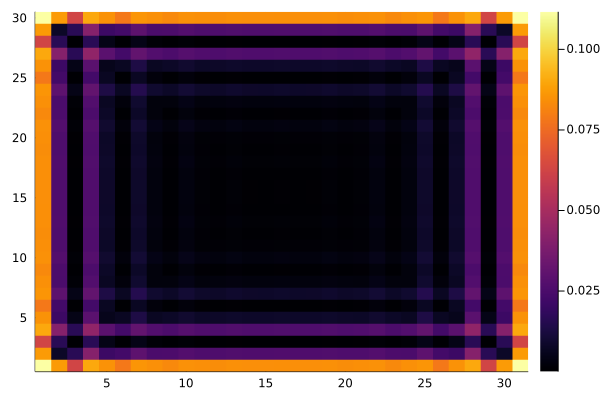

In [18]:
edgewave = Wave[:,(Eigen.>1.2).&(Eigen.<1.8)]
stateToPlot = edgewave[:,1]
NumToPlot = norm.(stateToPlot)
NumToPlot = reshape(NumToPlot,(M,N))
heatmap(NumToPlot)

It's exactly an edge state!!!!